In [1]:
import numpy as np
import pandas as pd
from numpy.fft import fft, rfft
from scipy.stats import skew, kurtosis
import csv, mne, math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
target = "chb16"
file = "chb16_14.edf"
drive_path = "C:/Users/Eugene Chen/Desktop/UNI/Project/Data/"
seizure_pointers = pd.read_excel(drive_path + "seizure data.xlsx", index_col=0)
seizure_pointers["index"] = (
    seizure_pointers["seizure_file"]
    + " "
    + seizure_pointers["seizure_number"].astype(str)
)
record_path = drive_path+"/"+target+file
channels = [
    "P8-O2",
    "C4-P4",
    "FP1-F3",
    "FP2-F8",
    "CZ-PZ",
    "FP1-F7",
    "T7-P7",
    "C3-P3",
    "FP2-F4",
    "P4-O2",
    "F8-T8",
    "F7-T7",
    "F3-C3",
    "FZ-CZ",
    "P3-O1",
    "P7-O1",
    "F4-C4",
]
patient = seizure_pointers[seizure_pointers["index"] == "chb16_14 1"]

In [3]:
patient["case"].values[0]

'chb16'

In [4]:
seizure_start = patient.seizure_start.values[0]
seizure_duration = patient.seizure_duration.values[0]
edf_data = mne.io.read_raw_edf(
            drive_path
            + "chb-mit-scalp-eeg-database-1.0.0/"
            + patient.case.values[0]
            + "/"
            + patient.seizure_file.values[0]
            + ".edf/",
            preload=True,
            verbose=50
        )
edf_data.filter(h_freq=40, l_freq=0, verbose=False)
edf_data.drop_channels(list(set(edf_data.ch_names) - set(channels)))
seizures = mne.Annotations(
                onset=seizure_start, duration=seizure_duration, description="bad"
            )
edf_data.set_annotations(seizures)
seizure_sample = mne.concatenate_raws(
                edf_data.crop_by_annotations(), verbose=50
            )
non_seizures = mne.make_fixed_length_epochs(
                edf_data, seizure_duration, reject_by_annotation=True, verbose=50
            )

In [172]:
sample_id = 30
channel = 4

no_seizure = non_seizures[sample_id]._get_data(verbose=50)[0][channel]
sample_len = no_seizure.shape[0]
seizure = seizure_sample.get_data()[channel][:sample_len]
step = seizure_duration/sample_len
x = np.arange(0, seizure_duration, step)


In [6]:
sns.set(font='arial',
        rc={
            'axes.edgecolor': 'lightgrey',
            'axes.facecolor': 'None',
            'axes.grid': False,
            'axes.labelcolor': 'dimgrey',
            'axes.spines.right': False,
            'axes.spines.top': False,
            'figure.facecolor': 'white',
            'lines.solid_capstyle': 'round',
            'patch.edgecolor': 'w',
            'patch.force_edgecolor': True,
            'text.color': 'dimgrey',
            'xtick.bottom': False,
            'xtick.color': 'dimgrey',
            'xtick.direction': 'out',
            'xtick.top': False,
            'ytick.color': 'dimgrey',
            'ytick.direction': 'out',
            'ytick.left': False,
            'axes.axisbelow': False,
            'ytick.right': False})

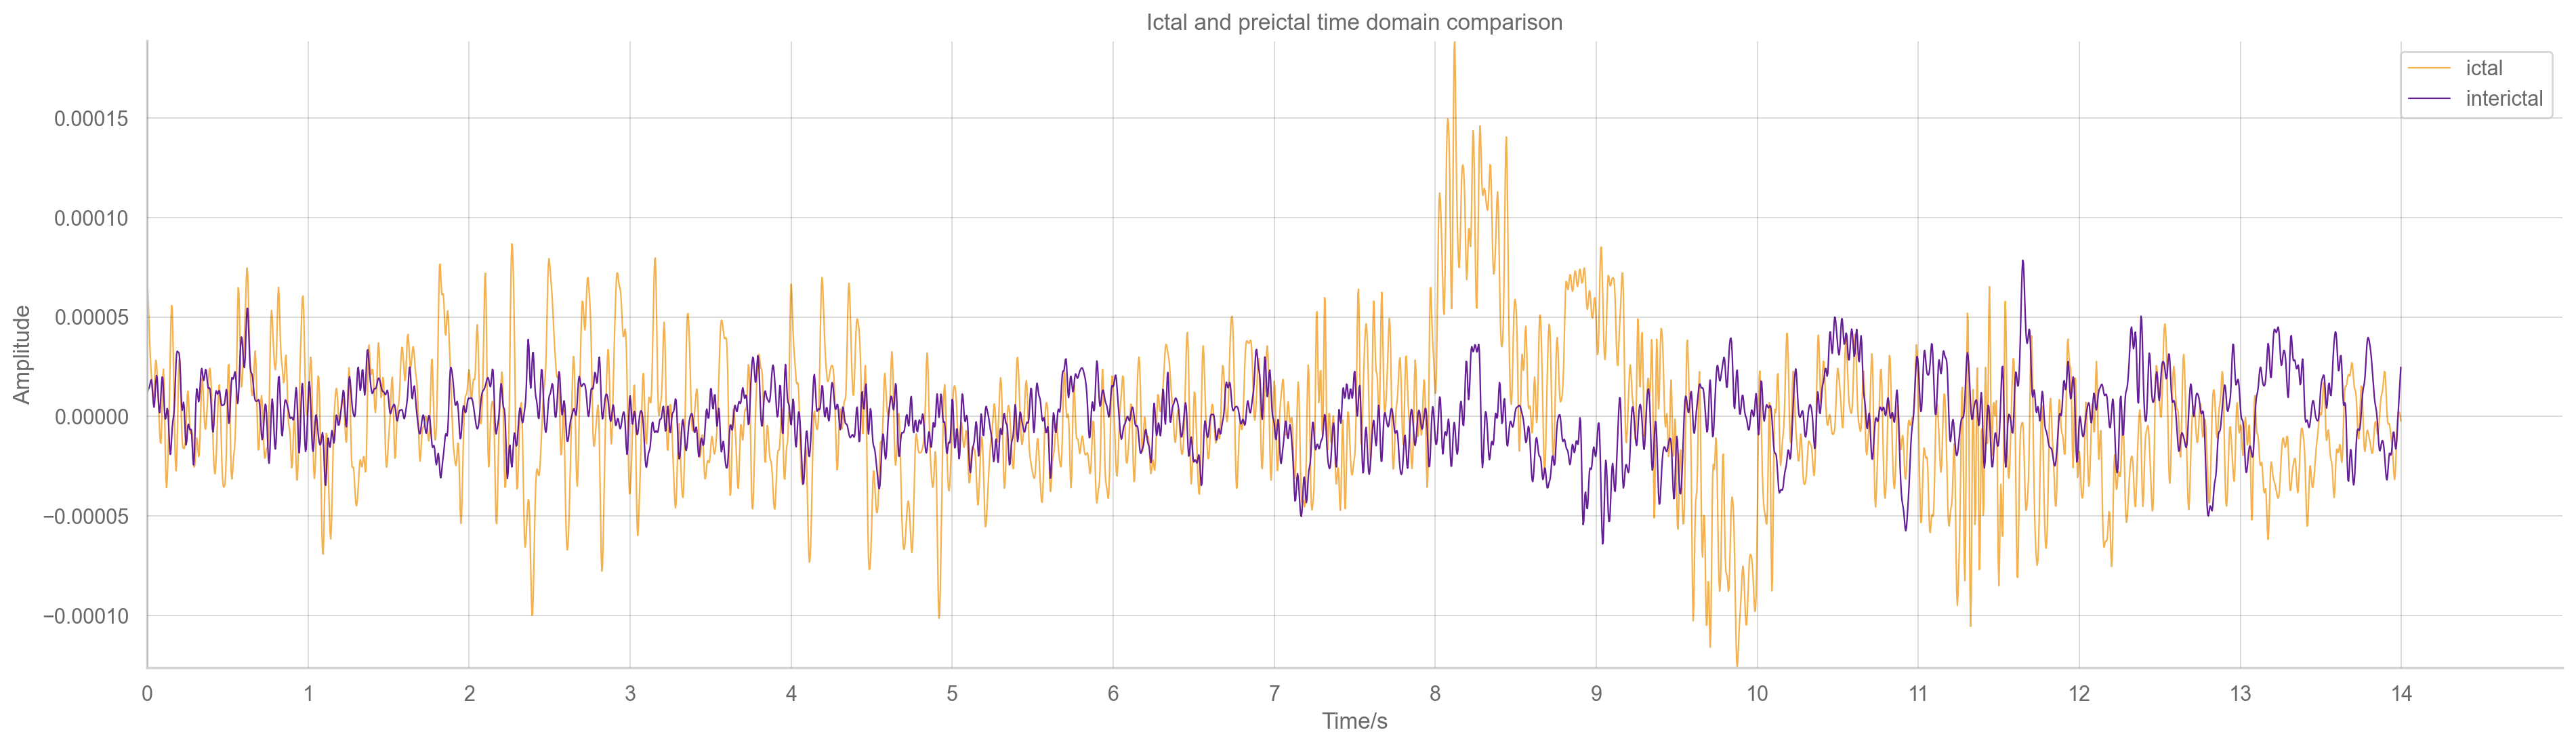

In [7]:
fig, ax = plt.subplots(figsize=(23, 6), dpi=200)
ax.grid(color='black', linestyle='-', linewidth=0.1)
ax.set_xticks(np.arange(0, 15, 1)) 
ax.axis(xmin=0,xmax=15,ymax=seizure.max(),ymin=seizure.min())
ax.plot(x, seizure, color ='#F5B14C', linewidth=0.8, label="ictal")
ax.plot(x, no_seizure, color ='#661D98', linewidth=0.8, label="interictal")
ax.set_title("Ictal and preictal time domain comparison")
ax.set_xlabel("Time/s")
ax.set_ylabel("Amplitude")
ax.legend()

In [181]:
ictal_ft = abs(rfft(seizure))
ictal_ft = [ x.real for x in ictal_ft]
interictal_ft = abs(rfft(no_seizure))
interictal_ft = [ x.real for x in interictal_ft]
N = len(ictal_ft)
n = np.arange(N)
T = seizure_duration
freq = n/T
freq_sampling_rate = (freq<1).sum()

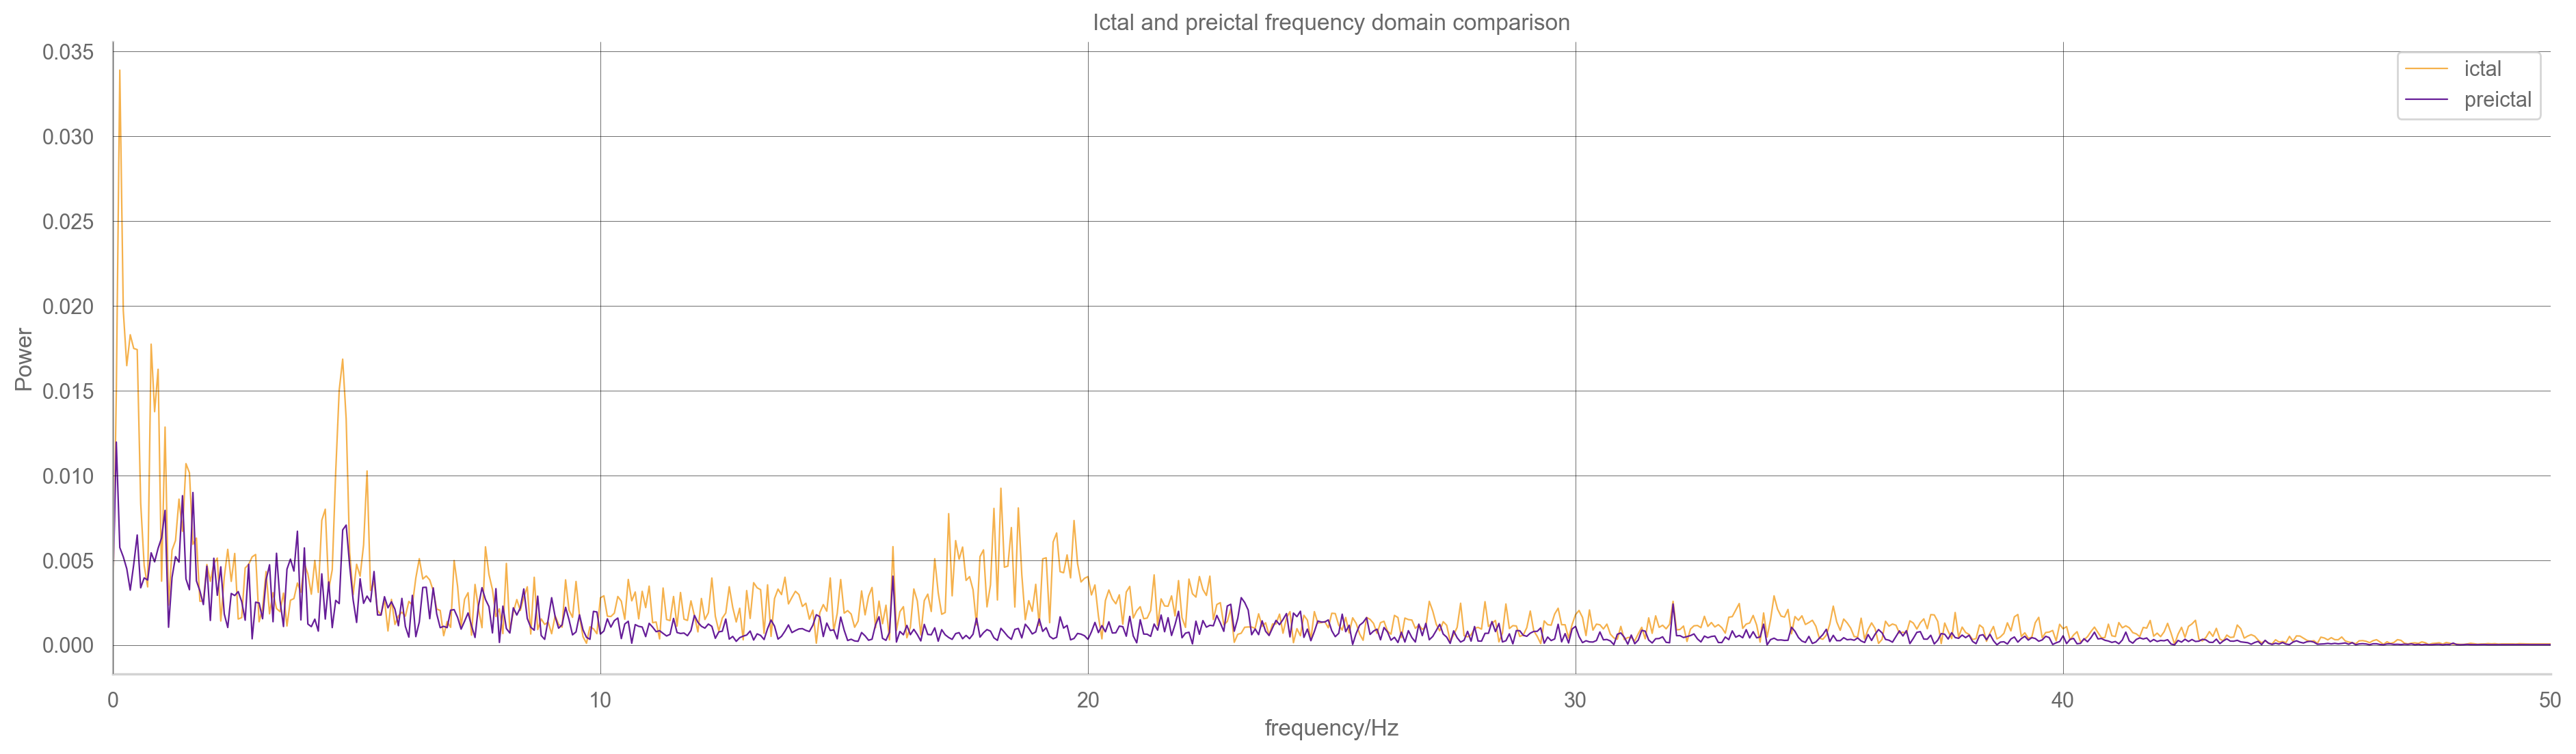

In [182]:
fig, ax = plt.subplots(figsize=(23, 6), dpi=200)
ax.grid(color='black', linestyle='-', linewidth=0.2)
# ax.axis(ymax=ictal_ft.max(),ymin=0)
ax.axis(xmin=0,xmax=50)
ax.plot(freq, ictal_ft, color ='#F5B14C', linewidth=0.8, label="ictal")
ax.plot(freq, interictal_ft, color ='#661D98', linewidth=0.8, label="preictal")
ax.set_title("Ictal and preictal frequency domain comparison")
ax.set_xlabel("frequency/Hz")
ax.set_ylabel("Power")
ax.legend()

In [184]:
def get_reduced_freq(target, batch_size, sampling_rate):
    result = []
    batch=[]
    for i in target[0:(sampling_rate*40)+1]:
        batch.append(i)
        if len(batch)==batch_size:
            batch_mean = sum(batch)/batch_size
            result.append(batch_mean)
            batch=[]
    return result

In [195]:
num_baches = 20
bach_size=int(freq_sampling_rate*40/num_baches)
ictal_ft_features = get_reduced_freq(ictal_ft, bach_size, 14)
interictal_ft_features = get_reduced_freq(interictal_ft, bach_size, 14)
reduced_ictal_ft  = [item for sublist in [[x]*bach_size for x in ictal_ft_features] for item in sublist]
reduced_interictal_ft = [item for sublist in [[x]*bach_size for x in interictal_ft_features] for item in sublist]

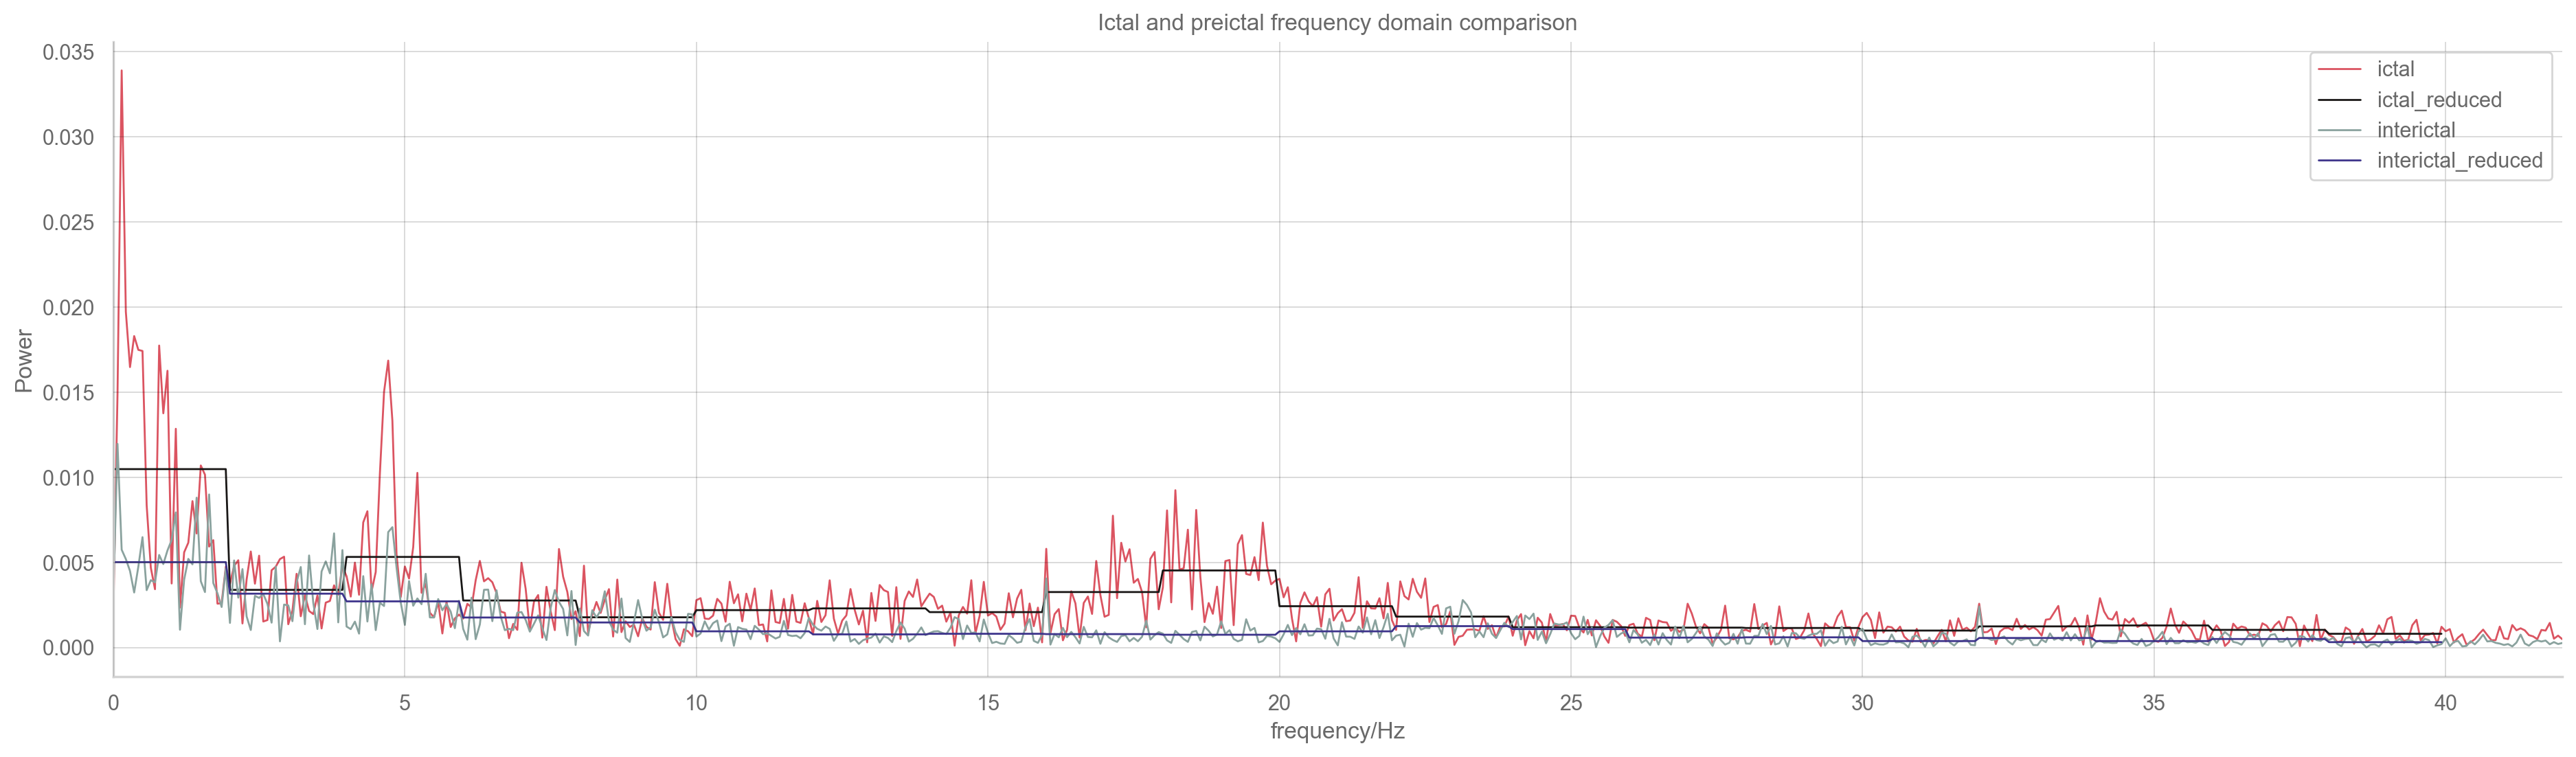

In [196]:
fig, ax = plt.subplots(figsize=(23, 6), dpi=200)
ax.grid(color='black', linestyle='-', linewidth=0.1)
ax.axis(xmin=0,xmax=42)
ax.plot(freq, ictal_ft, color ='#db5461', linewidth=1, label="ictal")
ax.plot(freq[0:freq_sampling_rate*40], reduced_ictal_ft, color ='#191716', linewidth=1, label="ictal_reduced")
ax.plot(freq, interictal_ft, color ='#8aa29e', linewidth=1, label="interictal")
ax.plot(freq[0:freq_sampling_rate*40], reduced_interictal_ft, color ='#3d348b', linewidth=1, label="interictal_reduced")
ax.set_title("Ictal and preictal frequency domain comparison")
ax.set_xlabel("frequency/Hz")
ax.set_ylabel("Power")
ax.legend()

matrix from all layers frequencies

In [209]:
num_baches = 20
bach_size=int(freq_sampling_rate*40/num_baches)
convolution_features_ictal = []
convolution_features_interictal = []
for channel in range(seizure_sample.get_data().shape[0]):
    seizure = seizure_sample.get_data()[channel][:sample_len]
    no_seizure = non_seizures[sample_id]._get_data(verbose=50)[0][channel]
    ictal_ft = abs(rfft(seizure))
    ictal_ft = [ x.real for x in ictal_ft]
    interictal_ft = abs(rfft(no_seizure))
    interictal_ft = [ x.real for x in interictal_ft]
    ictal_ft_features = get_reduced_freq(ictal_ft, bach_size, 14)
    interictal_ft_features = get_reduced_freq(interictal_ft, bach_size, 14)
    convolution_features_ictal.append(ictal_ft_features)
    convolution_features_interictal.append(interictal_ft_features)
    

In [214]:
bach_size

28

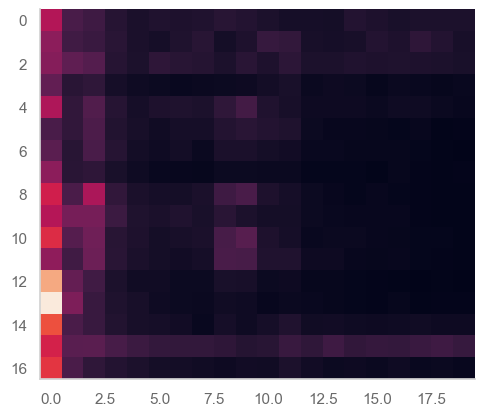

In [210]:
plt.imshow(convolution_features_ictal)

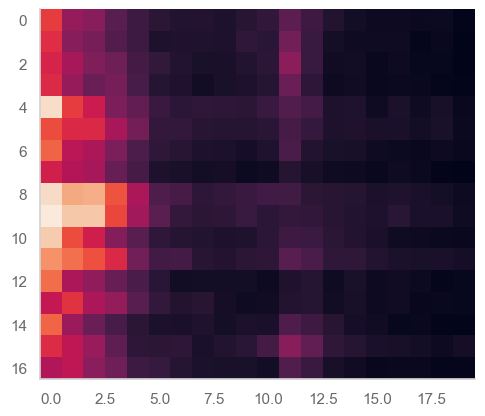

In [211]:
plt.imshow(convolution_features_interictal)